# Market Segmentation & Conjoint Analysis
Analyzed Lobster Land’s operations using k-means clustering to segment park days based on attendance, pricing, weather, and spending behavior, uncovering distinct day types to inform staffing, pricing, and marketing decisions. Conducted a conjoint analysis with a linear regression model to quantify how entertainment features, crowding, and experience design impact guest satisfaction, translating insights into actionable recommendations for revenue and experience optimization.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Part I: Segmentation

In [79]:
# Import day_25.csv files into python for use
day_25 = pd.read_csv("data/days25.csv")

In [80]:
# Then use info() and head() function to show how the data is stored
day_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Day_ID                  99 non-null     int64  
 1   Day_of_Week             99 non-null     object 
 2   season_week_rel         99 non-null     int64  
 3   Is_Holiday              99 non-null     int64  
 4   Total_Visitors          99 non-null     int64  
 5   Passholder_Percentage   99 non-null     float64
 6   Day_Tickets_Sold        99 non-null     int64  
 7   Avg_Ticket_Price        99 non-null     float64
 8   Gate_Revenue            99 non-null     float64
 9   Revenue_Food            99 non-null     float64
 10  Revenue_Merch           99 non-null     float64
 11  Revenue_Arcade          99 non-null     float64
 12  Total_Revenue           99 non-null     float64
 13  Total_Labor_Hours       99 non-null     float64
 14  International_Visitors  99 non-null     floa

In [81]:
day_25.head()

,Day_ID,Day_of_Week,season_week_rel,Is_Holiday,Total_Visitors,Passholder_Percentage,Day_Tickets_Sold,Avg_Ticket_Price,Gate_Revenue,Revenue_Food,Revenue_Merch,Revenue_Arcade,Total_Revenue,Total_Labor_Hours,International_Visitors,High_Temperature,Weather_Type,Is_Special_Event,Per_Capita_Spend
0,1,Monday,1,1,1769,48.65,908,77.42,70297.36,40521.91,15881.290,3195.46,129896.02,238.1,114.0,74.6,Thunderstorms,0,73.43
1,2,Tuesday,1,0,1717,60.58,677,69.80,47254.60,35298.92,15882.665,2977.63,101812.36,253.4,255.0,74.0,Partly Cloudy,0,59.30
2,3,Wednesday,1,0,1600,30.84,1107,70.09,77589.63,36495.95,14954.040,2683.58,131723.20,213.3,160.0,76.8,Partly Cloudy,0,82.33
3,4,Thursday,1,0,1037,19.02,840,72.30,60732.00,22486.65,9517.060,1831.98,94567.69,192.7,83.0,75.4,Showers,0,91.19
4,5,Friday,1,0,1671,66.18,565,68.11,38482.15,40705.15,15727.620,3115.94,98030.86,235.9,158.0,80.7,Partly Cloudy,0,58.67


In [82]:
# Convert binary flags (0,1) including: Is_Holiday and Is_Special_Event to categorical
day_25[['Is_Holiday','Is_Special_Event']] = day_25[['Is_Holiday','Is_Special_Event']].astype('category')

# Convert season_week_rel, Day_of_Week and Weather_Type from object to categorical variables
day_25[['Day_of_Week','season_week_rel','Weather_Type']] = day_25[['Day_of_Week','season_week_rel','Weather_Type']].astype('category')

In [83]:
# Drop the Day_ID variable
day_25 = day_25.drop(columns=["Day_ID"])

In this case, I decided to drop Day_ID because it's just a sequential label and doesn't seem to offer meaningful insight for analysis or prediction. Since it might unintentionally influence models by introducing artificial patterns, it felt more appropriate to leave it out of the feature set.

In [84]:
# Double check to see if all the variables are stored as the appropriate data type
day_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Day_of_Week             99 non-null     category
 1   season_week_rel         99 non-null     category
 2   Is_Holiday              99 non-null     category
 3   Total_Visitors          99 non-null     int64   
 4   Passholder_Percentage   99 non-null     float64 
 5   Day_Tickets_Sold        99 non-null     int64   
 6   Avg_Ticket_Price        99 non-null     float64 
 7   Gate_Revenue            99 non-null     float64 
 8   Revenue_Food            99 non-null     float64 
 9   Revenue_Merch           99 non-null     float64 
 10  Revenue_Arcade          99 non-null     float64 
 11  Total_Revenue           99 non-null     float64 
 12  Total_Labor_Hours       99 non-null     float64 
 13  International_Visitors  99 non-null     float64 
 14  High_Temperature        99 n

- **Numeric Variables:** Total_Visitors, Passholder_Percentage, Day_Tickets_Sold, Avg_Ticket_Price, Gate_Revenue, Revenue_Food, Revenue_Merch, Revenue_Arcade, Total_Revenue, Total_Labor_Hours, International_Visitors, High_Temperature, Per_Capita_Spend
- **Categorical Variables:** Day_ID, Day_of_Week, season_week_rel, Is_Holiday, Weather_Type, Is_Special_Event

In my opinion, it's not a great idea to use categorical inputs in a k-means model because the algorithm calculates distances between data points, and turning categories into numbers can be misleading. Take season_week_rel for example, it uses values from 1 to 15 to represent different weeks, but those numbers don’t really capture how similar or different the weeks are in terms of things like visitor patterns or revenue. The model might end up grouping week 1 and week 2 together just because their numbers are close, even if they behave very differently. Since k-means tries to minimize distance within clusters, it could create groups that look related mathematically but don’t actually make much sense in the real-world context of the data.

#### Call the describe() function on your dataset.

In [85]:
day_25.describe()

,Total_Visitors,Passholder_Percentage,Day_Tickets_Sold,Avg_Ticket_Price,Gate_Revenue,Revenue_Food,Revenue_Merch,Revenue_Arcade,Total_Revenue,Total_Labor_Hours,International_Visitors,High_Temperature,Per_Capita_Spend
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1870.707071,41.973232,1098.292929,70.439697,79484.778182,54715.882626,18691.392273,4450.617879,147911.785253,256.535354,178.464646,77.126263,76.930808
std,641.078735,15.581994,466.750518,10.680450,37053.465251,97737.730733,8077.026667,2992.738130,62854.729274,47.232843,85.522800,13.975537,12.582334
min,-50.000000,11.720000,322.000000,-25.000000,22350.020000,22486.650000,9517.060000,1831.980000,63247.570000,192.700000,-10.000000,63.800000,51.630000
25%,1482.000000,28.895000,771.000000,68.250000,53853.740000,33291.365000,13492.635000,2693.595000,103186.105000,222.400000,117.500000,70.850000,68.575000
50%,1704.000000,40.900000,995.000000,70.480000,70272.360000,38054.660000,15882.665000,3026.520000,129433.130000,243.500000,158.000000,74.800000,77.500000
75%,2080.000000,54.590000,1411.000000,73.735000,103147.720000,55612.790000,22567.790000,5419.410000,184173.685000,272.000000,232.500000,81.350000,84.385000
max,3938.000000,73.650000,3029.000000,82.280000,242229.130000,999999.990000,51601.440000,15755.610000,423019.370000,435.400000,560.000000,200.000000,110.860000


When I run the describe() function on this dataset, it provides a concise statistical summary of each numeric column, including the count, mean, standard deviation, and range values. This snapshot helps me quickly understand the distribution and behavior of each variable, which is essential for assessing data quality and preparing for modeling.

In this case, the summary reveals several problematic entries that need attention. For example, *Total_Visitors*, *International_Visitors*, and *Avg_Ticket_Price* contain negative values, which are not realistic in the context of theme park operations. Another noticeable issue in the summary table is that *Revenue_Food* shows a maximum value of 999,999.99, which exceeds the *Total_Revenue* maximum of 423,019.37, even though *Total_Revenue* should represent the combined daily revenue across all categories (gate, food, merchandise, and arcade). Identifying these issues early allows me to flag potential data entry errors or outliers and decide whether to clean, transform, or exclude certain records. This step is crucial for ensuring that the model is built on reliable and interpretable data.

#### Missing values / Impossible values

In [86]:
day_25.isnull().sum()

Day_of_Week               0
season_week_rel           0
Is_Holiday                0
Total_Visitors            0
Passholder_Percentage     0
Day_Tickets_Sold          0
Avg_Ticket_Price          0
Gate_Revenue              0
Revenue_Food              0
Revenue_Merch             0
Revenue_Arcade            0
Total_Revenue             0
Total_Labor_Hours         0
International_Visitors    0
High_Temperature          0
Weather_Type              0
Is_Special_Event          0
Per_Capita_Spend          0
dtype: int64

After running the code and checking the results for missing values, the output indicates that all columns contain zero missing values, suggesting that the dataset is complete and no data cleaning through imputation or row removal is necessary.

In [87]:
day_25.select_dtypes(include="number").lt(0).sum()

Total_Visitors            1
Passholder_Percentage     0
Day_Tickets_Sold          0
Avg_Ticket_Price          1
Gate_Revenue              0
Revenue_Food              0
Revenue_Merch             0
Revenue_Arcade            0
Total_Revenue             0
Total_Labor_Hours         0
International_Visitors    1
High_Temperature          0
Per_Capita_Spend          0
dtype: int64

In [88]:
# Look for rows with negative values in Total_Visitors, Avg_Ticket_Price and International_Visitors 
day_25[(day_25["Total_Visitors"] < 0) | 
       (day_25["Avg_Ticket_Price"] < 0) | 
       (day_25["International_Visitors"] < 0)]

,Day_of_Week,season_week_rel,Is_Holiday,Total_Visitors,Passholder_Percentage,Day_Tickets_Sold,Avg_Ticket_Price,Gate_Revenue,Revenue_Food,Revenue_Merch,Revenue_Arcade,Total_Revenue,Total_Labor_Hours,International_Visitors,High_Temperature,Weather_Type,Is_Special_Event,Per_Capita_Spend
10,Thursday,2,0,-50,72.26,444,69.49,30853.56,40019.25,15179.56,2722.04,88774.41,228.6,75.0,82.4,Partly Cloudy,0,55.52
20,Sunday,3,0,2691,27.24,1958,-25.00,146771.68,67432.83,26147.56,7571.99,247924.06,305.3,178.0,79.5,Cloudy,0,92.13
50,Tuesday,8,0,1204,72.60,330,68.39,22568.70,27999.37,11246.96,2202.88,64017.91,205.4,-10.0,78.0,Rain,0,53.17


In [89]:
# Find rows with suspiciously high food revenue
day_25[day_25["Revenue_Food"] > day_25["Total_Revenue"]]

,Day_of_Week,season_week_rel,Is_Holiday,Total_Visitors,Passholder_Percentage,Day_Tickets_Sold,Avg_Ticket_Price,Gate_Revenue,Revenue_Food,Revenue_Merch,Revenue_Arcade,Total_Revenue,Total_Labor_Hours,International_Visitors,High_Temperature,Weather_Type,Is_Special_Event,Per_Capita_Spend
30,Wednesday,5,0,1772,18.77,1439,69.82,100470.98,999999.99,16262.36,2974.24,165467.64,238.3,137.0,86.4,Cloudy,0,93.38


In [90]:
# Find rows with suspiciosly high temperature 
day_25[day_25["High_Temperature"] > 120]

,Day_of_Week,season_week_rel,Is_Holiday,Total_Visitors,Passholder_Percentage,Day_Tickets_Sold,Avg_Ticket_Price,Gate_Revenue,Revenue_Food,Revenue_Merch,Revenue_Arcade,Total_Revenue,Total_Labor_Hours,International_Visitors,High_Temperature,Weather_Type,Is_Special_Event,Per_Capita_Spend
40,Saturday,6,0,1933,25.14,1447,74.99,108510.53,54861.67,19528.12,5038.63,187938.95,251.4,194.0,200.0,Rain,0,97.23


To identify impossible values, I focused on numeric variables and used the command
day_25.select_dtypes(include="number").lt(0).sum(). This function isolates numeric columns and checks for any values less than zero, providing a quick count of negative entries per column. This approach is useful because variables like visitor counts, ticket sales, and revenue figures cannot logically be negative in a theme park setting. At the same time, *Passholder_Percentage* falls within a reasonable 0–100% range, so those values appear consistent.

The results showed three impossible values in *Total_Visitors, International_Visitors, and Avg_Ticket_Price*. These values are considered impossible because visitor counts cannot be negative - they must be zero or greater. Similarly, ticket prices are typically non-negative, unless there's a rare case involving refunds or discounts. In this context, negative values likely indicate data entry errors or corrupted records. 

The summary statistics also showed that *Revenue_Food* has a maximum value of 999,999.99, whereas Total_Revenue only has a maximum of 423,019.37. Because Total_Revenue should include all revenue categories, this should be corrected or reviewed before any further analysis.

Another entry that appears suspicious is *High_Temperature*, which shows a maximum value of 200°F. While temperature ranges can vary by region, typical readings in the United States generally fall between 0°F and a little over 100°F. Even Boston’s recent heatwave only reached a record high of 102°F, so a value of 200°F is unrealistic. To verify, I filtered the *High_Temperature* variable for values greater than 120°F and found only one record, suggesting this is likely a data entry or recording error.

#### If so, handle them in any way that you see fit. 

In [91]:
# Drop rows where Food_Revenue exceeds Total_Revenue
day_25 = day_25[day_25["Revenue_Food"] <= day_25["Total_Revenue"]]

In this case, the simplest and most reasonable solution is to remove the entire row, since even if I replaced *Revenue_Food* with a typical value (like the median), *Total_Revenue* would still end up smaller than the sum of its parts, which doesn’t make sense for this dataset.

In [92]:
# Drop rows where  High_Temperature is abnormally high
day_25 = day_25[day_25["High_Temperature"] <= 120]

I decided to remove the row with the unusually high temperature value instead of imputing it with the median, since it appeared to be an outlier that could distort the results. By removing it, I ensure the dataset remains accurate and free from unrealistic values. 

In [93]:
# Filter so that all variables is non-negative
day25 = day_25[
    (day_25["Total_Visitors"] >= 0) &
    (day_25["Avg_Ticket_Price"] >= 0) &
    (day_25["International_Visitors"] >= 0)
]

day25.select_dtypes(include="number").lt(0).sum()

Total_Visitors            0
Passholder_Percentage     0
Day_Tickets_Sold          0
Avg_Ticket_Price          0
Gate_Revenue              0
Revenue_Food              0
Revenue_Merch             0
Revenue_Arcade            0
Total_Revenue             0
Total_Labor_Hours         0
International_Visitors    0
High_Temperature          0
Per_Capita_Spend          0
dtype: int64

In [94]:
# Now, day25 dataframe has 94 entries for each variable after dropping the 5 impossible rows.
day25.count()

Day_of_Week               94
season_week_rel           94
Is_Holiday                94
Total_Visitors            94
Passholder_Percentage     94
Day_Tickets_Sold          94
Avg_Ticket_Price          94
Gate_Revenue              94
Revenue_Food              94
Revenue_Merch             94
Revenue_Arcade            94
Total_Revenue             94
Total_Labor_Hours         94
International_Visitors    94
High_Temperature          94
Weather_Type              94
Is_Special_Event          94
Per_Capita_Spend          94
dtype: int64

I chose to drop the rows with impossible values rather than replace them with the median or mode because the errors are rare and clearly invalid. According to data_25.info() results above, I know that there are 99 entries for each variables. With only 5 affected entries out of 99, removing them avoids introducing assumptions that could distort relationships between variables. Replacing with typical values like the median might mask underlying issues or flatten meaningful variation, especially when the context behind the error is unknown. Dropping ensures the dataset remains clean and reasonable. 

#### Variable selection. Select any 5 variables from the potential set of inputs in order to build your k-means clustering model.

In [95]:
var_selected = day25[["Total_Visitors","Avg_Ticket_Price",
                       "High_Temperature","Passholder_Percentage","Per_Capita_Spend"]]

To build a meaningful k-means clustering model, I selected the following five variables from the dataset: *Total_Visitors, Avg_Ticket_Price, High_Temperature, Passholder_Percentage, and Per_Capita_Spend*. These five variables were chosen to capture key aspects of daily park dynamics. *Total_Visitors* reflects overall attendance, giving a sense of how busy the park is. *Avg_Ticket_Price* ties into pricing strategy and its potential influence on visitor volume. *High_Temperature* displays a weather factor that can affect both attendance and spending. *Passholder_Percentage* helps distinguish between loyal visitors and one-time guests, which may impact behavior and spending habits. *Per_Capita_Spend* offers a normalized view of how much each visitor contributes financially, combining attendance and revenue into a single meaningful metric.

#### Data Scaling
#### Do your variables need to be standardized? Why or why not?
Yes, I do think my variables should be standardized before applying k-means clustering. This is because they are measured on very different scales. For instance, *Avg_Ticket_Price* is no more than about $83, while Total_Visitors can reach nearly 4,000, which is a much larger numerical range. Similarly, *Passholder_Percentage* is expressed as a proportion (0–100%), and *High_Temperature* and *Per_Capita_Spend* also exist on their own distinct scales. Since k-means uses Euclidean distance to group observations, variables with larger numeric ranges would otherwise dominate the clustering process. Standardizing the data ensures that each variable contributes equally to distance calculations, leading to more balanced and meaningful clusters.

#### If your data requires standardization, use Python to convert your values into z-scores, and store the normalized data in a new dataframe. If not, proceed to the next step without changing the variables.

In [96]:
# Import scaler function to standardize dataframe
scaler = StandardScaler()
var_scaled = scaler.fit_transform(var_selected)
# Create a new dataframe with standardized values
var_scaled_df = pd.DataFrame(var_scaled, columns = var_selected.columns)

print(var_scaled_df.head())

   Total_Visitors  Avg_Ticket_Price  High_Temperature  Passholder_Percentage  \
0       -0.196940          1.312127         -0.163867               0.452158   
1       -0.281650         -0.361277         -0.259344               1.252239   
2       -0.472247         -0.297591          0.186213              -0.742262   
3       -1.389393          0.187740         -0.036565              -1.534966   
4       -0.356585         -0.732412          0.806810               1.627801   

   Per_Capita_Spend  
0         -0.285287  
1         -1.460976  
2          0.455238  
3          1.192436  
4         -1.513395  


#### Elbow Chart

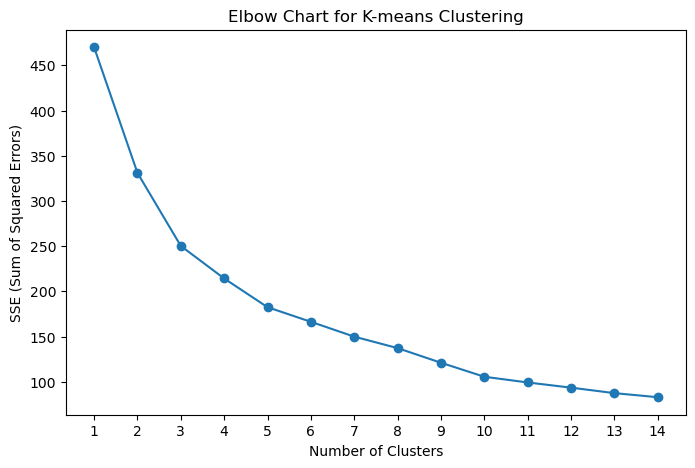

In [97]:
# Define X with 5 selected columns from the standardized data
X = var_scaled_df[["Total_Visitors",
                   "Avg_Ticket_Price",
                   "High_Temperature",
                   "Passholder_Percentage",
                   "Per_Capita_Spend"
                  ]]

# Build the elbow chart
sse = []
cluster_range = range(1, 15)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=616)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the Elbow chart
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Chart for K-means Clustering")
plt.xticks(cluster_range)
plt.show()

#### How many clusters will you use for your k-means model? 
The elbow chart above shows the SSE decreasing sharply from around 480 to approximately 175 as the number of clusters increases. The most significant drop occurs between 1 and 4 clusters, after which the curve begins to flatten, suggesting diminishing returns from adding more clusters. Based on this pattern, I selected k = 4 for the k-means model, as it captures most of the variance in the data while maintaining a manageable number of segments.

A smaller number of clusters (e.g., 2 or 3) would likely combine distinct park-day types, such as slower weekdays and peak weekends - into the same group, masking meaningful operational differences. By using four clusters, the park can better understand how key factors like visitor volume, pricing, weather, and spending behavior interact across different day types.

#### Build a k-means model with your desired number of clusters.

In [98]:
# Build and fit the K-Means model on the standardized DataFrame 'X'
kmeans_model = KMeans(n_clusters = 4, random_state = 616)
kmeans_model.fit(X)

# Add cluster labels to the original standardized df
var_scaled_df['Cluster'] = kmeans_model.labels_

print("K-Means Cluster Centers (for 4 clusters):")
print(var_scaled_df)

K-Means Cluster Centers (for 4 clusters):
    Total_Visitors  Avg_Ticket_Price  High_Temperature  Passholder_Percentage  \
0        -0.196940          1.312127         -0.163867               0.452158   
1        -0.281650         -0.361277         -0.259344               1.252239   
2        -0.472247         -0.297591          0.186213              -0.742262   
3        -1.389393          0.187740         -0.036565              -1.534966   
4        -0.356585         -0.732412          0.806810               1.627801   
..             ...               ...               ...                    ...   
89       -0.742667         -0.567707         -0.084304              -0.679222   
90       -0.242553         -0.211944         -1.325497              -0.760370   
91        1.531466          1.031030         -0.609424              -0.212452   
92       -0.009601         -0.225120         -0.800377               0.871312   
93        0.837497          0.752130         -0.338907             

I built the k-means model using a data frame containing only the 5 selected variables. By setting random_state = 616, I ensured that the clustering results remain consistent across runs. I selected 3 clusters to achieve a more detailed and meaningful segmentation of the park.

#### Generate Centroid Values

In [99]:
# Calculate centroid values for each cluster
centroids = var_scaled_df.groupby('Cluster').mean()

# Display the centroids
print(centroids)

         Total_Visitors  Avg_Ticket_Price  High_Temperature  \
Cluster                                                       
0             -0.592234         -0.358172         -0.670880   
1             -0.295578         -0.381371          1.168029   
2              1.977070          1.522274          0.319635   
3             -0.081737         -0.055474         -0.251885   

         Passholder_Percentage  Per_Capita_Spend  
Cluster                                           
0                     0.643200         -0.830625  
1                     0.596481         -0.552168  
2                     0.303739          0.530955  
3                    -1.079094          0.882159  


In [100]:
cluster_counts = var_scaled_df['Cluster'].value_counts().sort_index()
print("\nCluster Counts:")
print(cluster_counts)


Cluster Counts:
Cluster
0    29
1    20
2    13
3    32
Name: count, dtype: int64


#### Build four simple visualizations to help management better understand your clusters
#### Visualization 1: Histogram of Total Visitors by Cluster

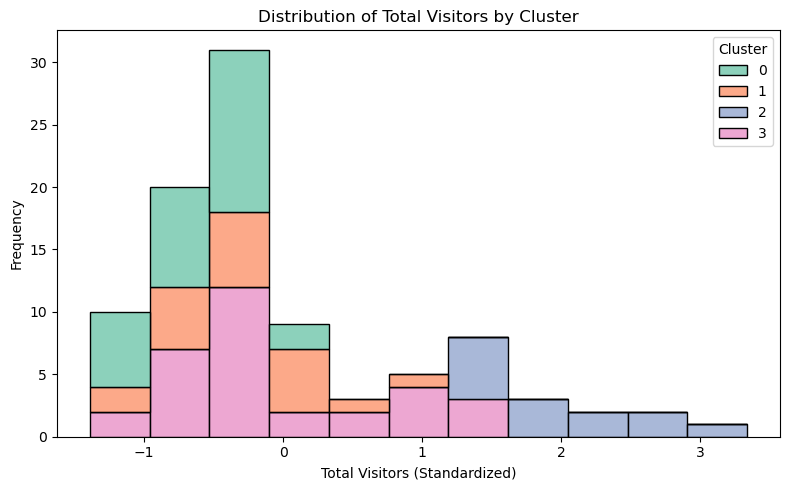

In [101]:
plt.figure(figsize=(8, 5))
sns.histplot(data=var_scaled_df, x="Total_Visitors", hue="Cluster", multiple="stack", palette="Set2")
plt.title("Distribution of Total Visitors by Cluster")
plt.xlabel("Total Visitors (Standardized)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

This histogram shows the distribution of Total Visitors(standardized) across the four clusters groupped by the model, with the x-axis representing Total Visitors to Lobster Land and the y-axis showing their frequency. Cluster 0 (green) is concentrated around lower standardized visitor counts, suggesting it represents quieter, low-traffic days. Cluster 1 (orange) sits in the middle, reflecting moderate visitor days, not too busy nor too quiet. Cluster 2 (blue) dominates the higher end of the scale, capturing peak attendance periods, while Cluster 3 (pink) spans wider range, suggesting it includes a more diverse mix of visitors who vary from occasional guests to highly engaged ones. 

Although this is a simple chart, it’s crucial for Lobster Land, as it clearly shows how each cluster reacts differently in terms of attendance and helps the team plan targeted promotions and engagement strategies tailored to each group’s behavior.

#### Visualization 2: Barplot Average Ticket Price per Cluster

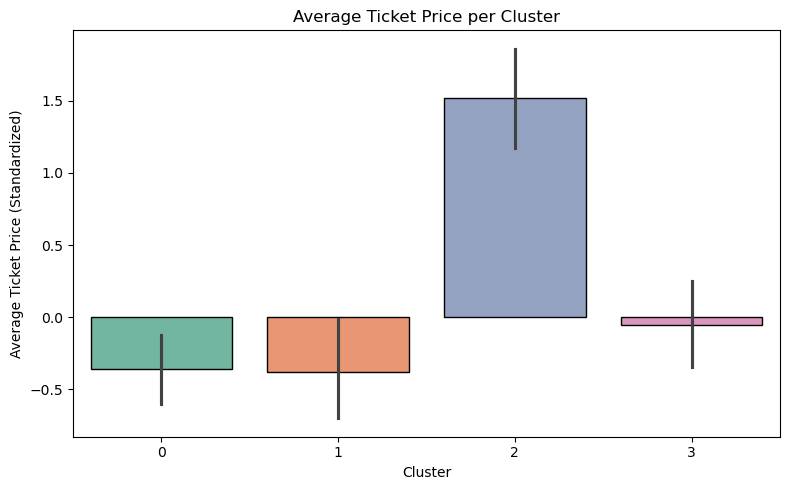

In [102]:
plt.figure(figsize=(8, 5))
sns.barplot(data=var_scaled_df, x="Cluster", y="Avg_Ticket_Price", hue="Cluster", palette="Set2", dodge=False, legend=False, edgecolor="black")
plt.title("Average Ticket Price per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Ticket Price (Standardized)")
plt.tight_layout()
plt.show()

This bar chart illustrates the mean standardized average ticket price across the four clusters identified by the model. Cluster 2 (blue) shows the highest average ticket price, representing premium or high-demand days. Clusters 0 (green) and 1 (orange) display below-average ticket prices, with Cluster 1 slightly lower than Cluster 0, indicating more budget-friendly or passholder-heavy days. Cluster 3 (pink) remains close to the standardized mean, reflecting more typical pricing conditions across Lobster Land’s visitor segments. This chart helps Lobster Land better understand how ticket prices vary across different visitor groups, allowing the team to align pricing strategies and promotions with each segment’s spending behavior.

#### Visualization 3: Scatterplot of Passholder Percentage vs Per Capita Spend colored by Cluster

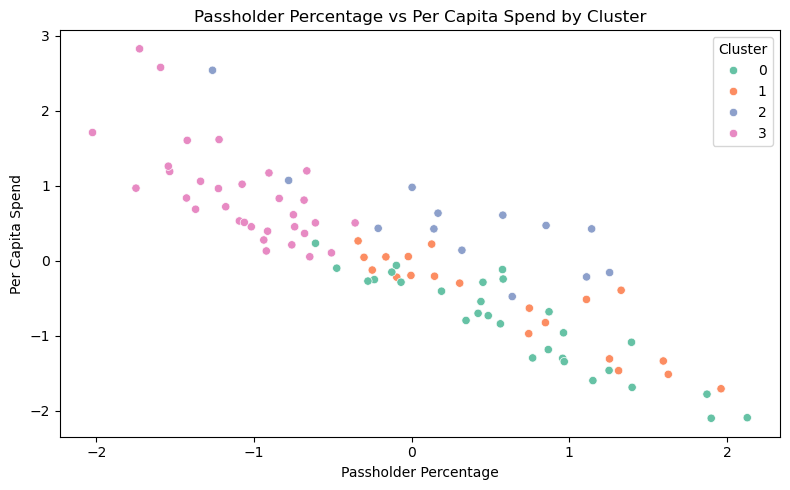

In [103]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=var_scaled_df, x="Passholder_Percentage", y="Per_Capita_Spend", hue="Cluster", palette="Set2")
plt.title("Passholder Percentage vs Per Capita Spend by Cluster")
plt.xlabel("Passholder Percentage")
plt.ylabel("Per Capita Spend")
plt.tight_layout()
plt.show()

This scatter plot shows how Passholder Percentage relates to Per Capita Spend across the four clusters identified by the model. I noticed a clear pattern where clusters with a higher share of passholders tend to have lower spending per person, while those with fewer passholders show higher spending levels. Cluster 0 (green) has a wide range of passholder percentages but generally lower spending, whereas Cluster 3 (pink) stands out with a smaller share of passholders and higher spending, likely representing one-time or premium visitors. Whereas Cluster 2 (blue) shows a distinct profile, with moderate passholder percentages and positive per capita spending, reflecting a balanced mix of loyal and casual visitors at Lobster Land. From this chart, we can see how different visitor types behave at Lobster Land, helping identify ways to balance loyalty programs with opportunities to attract higher-value guests.

#### Visualization 4: Boxplot High_Temperature per Cluster

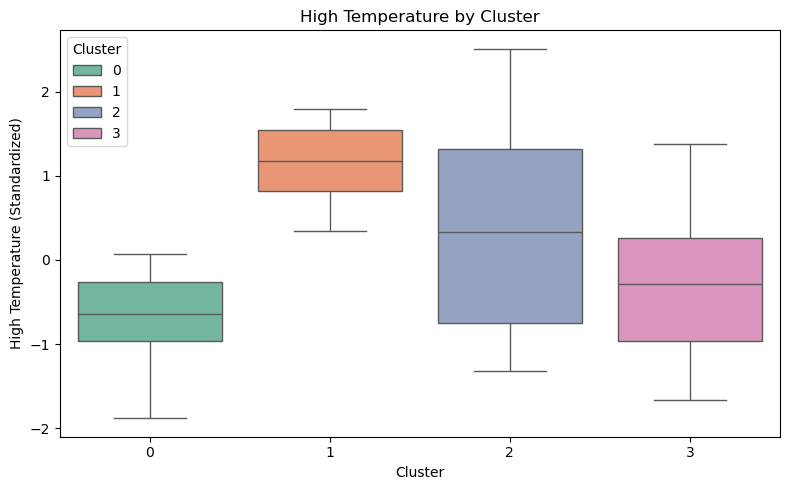

In [104]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=var_scaled_df, x="Cluster", y="High_Temperature", hue="Cluster", palette="Set2", dodge=False)
plt.title("High Temperature by Cluster")
plt.xlabel("Cluster")
plt.ylabel("High Temperature (Standardized)")
plt.tight_layout()
plt.show()

This boxplot shows how standardized high temperatures vary across the four clusters identified by the model. Cluster 1 (orange) has the highest median temperature, representing hotter days, while Clusters 0 (green) and 3 (pink) are generally cooler. Cluster 2 (blue) shows the widest temperature range, including both hot and cool days, which may reflect mixed or transitional seasonal conditions at Lobster Land.

#### Cluster Descriptions

#### Cluster 0: “Chill & Sparse”
These are the cool, calm days with lower visitor counts, below-average ticket prices, and a higher share of passholders. Spending per person is lighter, creating an easygoing park atmosphere that appeals to loyal guests and locals who enjoy a quieter visit.
- **Targeting:** LobsterLand can focus on community connections and rewarding frequent visitors on these days. Promotions highlighting relaxed park experiences, quiet attractions, or weekday benefits can draw local families and passholders seeking a slower, more comfortable visit.

#### Cluster 1: “Scorch & Stroll”
This cluster displays the warmest temperatures, moderate attendance, and lower ticket prices. Spending per capita is modest, and many visitors hold passes, creating a steady but easygoing flow of activity across the park.
- **Targeting:** The marketing team can emphasize refreshment and comfort through shaded seating, cool treat bundles or special water rides. Bright and refreshing summer campaigns that highlight leisurely fun and family-friendly attractions can reach guests looking for simple, enjoyable park days.

#### Cluster 2: “Gold Rush Days”
Cluster 2 represents the park’s busiest, most profitable days with high visitor counts, the highest standardized ticket prices, and strong per capita spending. With a balanced mix of loyal and casual visitors, these are the moments when the park operates at full capacity and captures its greatest market potential.
- **Targeting:** These days can spotlight premium experiences such as fast passes, dining packages, and exclusive access areas. Promotions on travel platforms and event partnerships can reach visitors planning full-day trips or group outings, aligning offerings with elevated park energy and spending activity.

#### Cluster 3: “Balanced Buzz”
This cluster shows moderate temperatures, mixed visitor counts, and steady spending levels. Ticket prices remain close to the average, and the lower passholder percentage suggests a healthy mix of new and returning guests.
- **Targeting:** With a blend of loyal customers and newcomers, LobsterLand can use this opportunity to run limited-time offers, themed events, or new experiences can help identify emerging interests.

#### How can Lobster Land use this model?
Lobster Land can use this day-type clustering model as a practical tool to help the team make better decisions about staffing, pricing, and creating great experiences for guests. By figuring out which cluster an upcoming day fits into, like a busy "Gold Rush Day" or a quieter "Chill & Sparse" day, the team can get ahead of operations instead of just reacting. On high-traffic days, the park can bring in extra staff, stay open later, and offer special upgrades that guests will actually want. On slower days, there's room to focus on rewarding regulars, running leaner operations, or taking care of behind-the-scenes maintenance that's hard to do when the park is packed.

The marketing team can also use these insights to shape promotions that actually fit the day. Take "Scorch & Stroll" days, for instance. These hot, leisurely days might be perfect for promoting cold drink bundles or access to shaded seating areas. "Balannced Buzz" days, with their unexpected energy, could be a testing ground for new attractions or digital campaigns to see what resonates. As Lobster Land builds out this approach, weaving in weather forecasts and calendar events could help predict cluster assignments days or even weeks ahead. That shifts the park from reactive scrambling to a proactive, rhythm-based planning style that aligns operations with real guest patterns and business priorities.

If the team could predict which cluster a day might fall into, it would make planning feel a lot more purposeful and efficient. For instance, if an upcoming weekend looks like a “Gold Rush Day,” the park could bring in extra staff, stock up on food and drinks, and roll out seasonal specials like fall-inspired treats or Halloween-themed beverages to attract both new visitors and returning fans. On the other hand, if a slower Tuesday seems to fall into the “Chill & Sparse” cluster, Lobster Land could use the opportunity to run local promotions, offer discounted afternoon passes, or host a cozy themed dining night for family and friends. This kind of planning helps the park stay balanced—keeping operations efficient, guests happy, and business decisions aligned with real demand.

## Part II: Conjoint Analysis with a Linear Model 

In [105]:
# Import night_show.csv files into python for use
night_show = pd.read_csv("/Users/nhattran/Downloads/MSBA/METAD654 - Marketing Analytics/assignment 2/night_show.csv",keep_default_na=False, na_values=[])

In [106]:
night_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73728 entries, 0 to 73727
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bundleID          73728 non-null  int64  
 1   headliner         73728 non-null  object 
 2   music_atmosphere  73728 non-null  object 
 3   show_length       73728 non-null  int64  
 4   peak_dB_Level     73728 non-null  int64  
 5   crowding_index    73728 non-null  int64  
 6   viewing_zone      73728 non-null  object 
 7   dining_bundle     73728 non-null  object 
 8   re_entry          73728 non-null  object 
 9   live_host         73728 non-null  object 
 10  charity_tie_in    73728 non-null  object 
 11  ratings           73728 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 6.8+ MB


In [107]:
night_show.head()

,bundleID,headliner,music_atmosphere,show_length,peak_dB_Level,crowding_index,viewing_zone,dining_bundle,re_entry,live_host,charity_tie_in,ratings
0,1,Fireworks,Pop Soundtrack,30,65,40,front plaza,None,None,Yes,Yes,4.249
1,2,Fireworks,Pop Soundtrack,30,65,40,front plaza,None,None,Yes,No/Doesn't Matter,4.689
2,3,Fireworks,Pop Soundtrack,30,65,40,front plaza,None,None,No/Doesn't Matter,Yes,7.999
3,4,Fireworks,Pop Soundtrack,30,65,40,front plaza,None,None,No/Doesn't Matter,No/Doesn't Matter,4.309
4,5,Fireworks,Pop Soundtrack,30,65,40,front plaza,None,One,Yes,Yes,6.239


Based on the 12 variables provided in the dataset, here's the list of numeric and categorical variables:
- **Numerical Variables:** show_length (in minutes); peak_dB_Level (decibels level); crowding_index (crowd density); ratings (average ratings from 0 t0 10).

- **Categorical Variables:** bundleID, headliner, music_atmosphere, viewing_zone, dining_bundle, re_entry, live_host, and charity_tie_in, as they represent distinct categories or labels rather than quantities with mathematical meaning.

- I also dropped bundleID from the dataset because it functions solely as a sequential identifier without providing any analytical or predictive value. Including it could potentially create misleading patterns in the model, so excluding it prevents future problems.

In [108]:
night_show = night_show.drop(columns=["bundleID"])

In [109]:
# Define the columns to convert
categorical_cols = ["headliner", "music_atmosphere", "viewing_zone", "dining_bundle",
                    "re_entry", "live_host", "charity_tie_in"]
# Convert to category dtype
night_show[categorical_cols] = night_show[categorical_cols].astype('category')

In [110]:
night_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73728 entries, 0 to 73727
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   headliner         73728 non-null  category
 1   music_atmosphere  73728 non-null  category
 2   show_length       73728 non-null  int64   
 3   peak_dB_Level     73728 non-null  int64   
 4   crowding_index    73728 non-null  int64   
 5   viewing_zone      73728 non-null  category
 6   dining_bundle     73728 non-null  category
 7   re_entry          73728 non-null  category
 8   live_host         73728 non-null  category
 9   charity_tie_in    73728 non-null  category
 10  ratings           73728 non-null  float64 
dtypes: category(7), float64(1), int64(3)
memory usage: 2.7 MB


#### Use the pandas get_dummies() function in order to prepare these variables for use in a linear model. Inside this function, include this argument: drop_first = True. Doing this will save us from the multicollinearity problem that would make our model unreliable.

In [111]:
# Before dummifying the variables, check to see if the dataset has any null input
night_show.isnull().values.any()

np.False_

In [112]:
night_show.columns

Index(['headliner', 'music_atmosphere', 'show_length', 'peak_dB_Level',
       'crowding_index', 'viewing_zone', 'dining_bundle', 're_entry',
       'live_host', 'charity_tie_in', 'ratings'],
      dtype='object')

In [113]:
night_show_dm = pd.get_dummies(night_show, drop_first=True, columns=['headliner', 'music_atmosphere', 'show_length', 'peak_dB_Level',
       'crowding_index', 'viewing_zone', 'dining_bundle', 're_entry','live_host', 'charity_tie_in'])

In [114]:
night_show_dm.head()

,ratings,headliner_Drone Light Show,headliner_Fireworks,headliner_Live Musical,music_atmosphere_Pop Soundtrack,show_length_70,show_length_110,show_length_150,peak_dB_Level_85,peak_dB_Level_105,...,viewing_zone_boardwalk,viewing_zone_castle_courtyard,viewing_zone_front plaza,dining_bundle_dessert_party,dining_bundle_meal_package,dining_bundle_snack_voucher,re_entry_One,re_entry_Unlimited,live_host_Yes,charity_tie_in_Yes
0,4.249,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,True
1,4.689,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2,7.999,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
3,4.309,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,6.239,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,True


In [115]:
night_show_dm.columns

Index(['ratings', 'headliner_Drone Light Show', 'headliner_Fireworks',
       'headliner_Live Musical', 'music_atmosphere_Pop Soundtrack',
       'show_length_70', 'show_length_110', 'show_length_150',
       'peak_dB_Level_85', 'peak_dB_Level_105', 'crowding_index_60',
       'crowding_index_80', 'crowding_index_100', 'viewing_zone_boardwalk',
       'viewing_zone_castle_courtyard', 'viewing_zone_front plaza',
       'dining_bundle_dessert_party', 'dining_bundle_meal_package',
       'dining_bundle_snack_voucher', 're_entry_One', 're_entry_Unlimited',
       'live_host_Yes', 'charity_tie_in_Yes'],
      dtype='object')

#### Why should the numeric input variables based on this survey data be dummified?
Numeric input variables from survey data should be converted into dummy variables because even though they appear as numbers, they represent discrete categories rather than continuous measurements. Take *show_length* for example, it might include values such as 30, 70, 110, and 150 minutes. These values are not part of a linear scale but rather specific options provided by the survey design. Treating them as continuous would incorrectly assume that the difference between 30 and 70 minutes has the same proportional relationship as the difference between 110 and 150 minutes, which may not reflect reality. 

By converting these numeric inputs into dummy variables, the model can assign independent effects to each category without imposing misleading linear assumptions. This approach improves both the accuracy and interpretability of the model while ensuring that the analysis respects the categorical structure inherent in survey-based numeric data.

#### It might seem tempting here to just skip the model-building step – instead of building a model, we could just rank the bundles by average rating, in descending order, and then just tell Lobster Land to implement all the features in the highest-rated bundle.
Ranking bundles by their average rating might seem ideal, but it hides the true drivers of guest satisfaction. Without building a model, it's difficult to tell which specific features within each bundle actually influence ratings or how they interact with one another. For example, a highly rated bundle might include both a live musical and unlimited re-entry, but we would not know that the musical boosts satisfaction while the re-entry option reduces it. A conjoint analysis model solves this by estimating the independent effect of each feature across all bundles, allowing Lobster Land to predict how new combinations would perform and design offerings that maximize impact while keeping costs manageable. In short, the model provides a deeper, data-driven understanding of guest preferences that simple ranking cannot achieve.

#### Build a linear model with your data, using the average rating as the outcome variable, and with all of your other variables (other than the bundleID) as inputs.
I build a linear regression model using all dummified input features to predict the average rating. This allows to estimate how each individual feature contributes to guest satisfaction.

In [116]:
# Create Linear Regression model
X = night_show_dm[['headliner_Drone Light Show', 'headliner_Fireworks',
       'headliner_Live Musical', 'music_atmosphere_Pop Soundtrack',
       'show_length_70', 'show_length_110', 'show_length_150',
       'peak_dB_Level_85', 'peak_dB_Level_105', 'crowding_index_60',
       'crowding_index_80', 'crowding_index_100', 'viewing_zone_boardwalk',
       'viewing_zone_castle_courtyard', 'viewing_zone_front plaza',
       'dining_bundle_dessert_party', 'dining_bundle_meal_package',
       'dining_bundle_snack_voucher', 're_entry_One', 're_entry_Unlimited',
       'live_host_Yes', 'charity_tie_in_Yes']]
y = night_show_dm["ratings"]

In [117]:
# Import LinearRegression function from scikit‑learn
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [118]:
regressor.intercept_
print(f"Intercept: {regressor.intercept_:.3f}")

Intercept: 4.953


In [119]:
import statsmodels.api as sm

# Define outcome and predictors
y = night_show_dm['ratings']
X_model = night_show_dm.drop(columns=['ratings'])

# Add intercept term
X_model = sm.add_constant(X_model)
# Convert boolean columns to numeric
bool_cols = X_model.select_dtypes(include=['bool']).columns
X_model[bool_cols] = X_model[bool_cols].astype(int)
X_model = X_model.astype(float)

# Fit the model
linear_model = sm.OLS(y, X_model).fit()
print(linear_model.summary())


                            OLS Regression Results                            
Dep. Variable:                ratings   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     1766.
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:53:46   Log-Likelihood:            -1.4678e+05
No. Observations:               73728   AIC:                         2.936e+05
Df Residuals:                   73705   BIC:                         2.938e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Display the coefficient values of your model inputs.
I extract and display the model’s coefficients to understand the direction and strength of each feature’s impact on ratings.

In [120]:
coef_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coef_df

,Coefficient
headliner_Drone Light Show,0.017789
headliner_Fireworks,0.000853
headliner_Live Musical,1.029869
music_atmosphere_Pop Soundtrack,-0.713001
show_length_70,0.717907
show_length_110,0.970937
show_length_150,0.703843
peak_dB_Level_85,0.016527
peak_dB_Level_105,-0.887189
crowding_index_60,0.223038


#### Write two-three paragraphs for Lobster Land management about what your model is showing you.

Dear Lobster Land Management Team,

I wanted to share some important findings from our conjoint analysis that can help guide decisions around evening entertainment programming. By examining guest survey responses across different features—headliner type, show length, sound levels, re-entry policies, and more—the analysis provides a clearer picture of what actually drives satisfaction and what might be holding the park back. The results show some strong patterns. Live Musical performances (coefficient of 1.03) and having a live host (0.84) make a significant positive impact on guest ratings, while unlimited re-entry (-1.59) and extremely loud sound at 105 dB (-0.89) actively hurt the experience. Shows running around 110 minutes (0.97) appear to be the ideal length, and high crowding levels (negative 0.60 at maximum capacity) clearly diminish satisfaction. These numbers help clarify not just what guests prefer, but how much each element matters when prioritizing investments and operational changes.

From a short-term planning perspective, there are several actionable takeaways. The 110-minute show format seems to be the best option where guests feel they're getting a full experience without it dragging on or feeling rushed. Although the unlimited re-entry sounds captivating, guests actually prefer having just one opportunity to leave and return, likely because unlimited access signals overcrowding or diminishes the sense of exclusivity. A simple re-entry policy could make guests feel they’re getting more value while also helping manage crowds better. Live musicals clearly offer the best experiences, but they also come with higher costs, tighter schedules, and more moving parts than drone shows or fireworks. The team will need to think carefully about when and how often to host live performances, especially during busy seasons when multiple shows a night could stretch both staff and resources.

Looking at longer-term strategy, the data suggests some interesting opportunities for tiered experiences. The park should offer premium ticket packages which allow guests to book particular less crowded viewing spots within standard capacity areas. This allows guests who value personal space to pay for that comfort while offering more budget-conscious visitors access at lower price points. Live hosts and charity partnerships, though subtle in impact, show how genuine connection and purpose-driven storytelling can make experiences more memorable and unique. On the dining side, bundles don’t boost satisfaction much, and snack vouchers may even hurt it, as guests often see them as low-value add-ons rather than real enhancements.

The key take-away is: prioritize live performances with engaging hosts, keep 110-minute show lengths, keep the sound levels part of the experience without being too overpowering, and manage crowds so visitors have room to enjoy themselves. By focusing on what matters most to customers (authentic experiences, good pacing, and making the evening special), the park can differentiate and create the evenings guests will come back for.